# Initialization 

### Imports 

In [3]:
#Fold

import numpy as np
np.random.seed(1337)  # for reproducibility

import os
os.environ["KERAS_BACKEND"] = "theano"
os.environ["image_dim_ordering"] = "tf"

os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN, device=cuda2, floatX=float32, exception_verbosity=high" 

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Concatenate, Add, Lambda, GlobalAveragePooling2D, Maximum
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import cv2
import matplotlib.pyplot as plt

try:
    from os import scandir, walk
except ImportError:
    from scandir import scandir, walk

ImportError: cannot import name np_utils

### Variable initializations

In [ ]:
#Fold

batch_size = 32
nb_classes = 3
nb_epoch = 60

mean = 0.38233018
std = 0.2534719

# input image dimensions
img_rows, img_cols = 245, 640


# 1. Data manipulation

### Load data

In [ ]:
#Fold

#    ---------MINISET---------

# train_src_directory = r'/notebooks/datasets/road_condition/miniset/train'
# test_src_directory = r'/notebooks/datasets/road_condition/miniset/test'
# X_train = np.memmap(os.path.join(train_src_directory, 'X_train_images.h5'), dtype='float32', mode='r', shape=(21701, 245, 640))
# Y_train = np.memmap(os.path.join(train_src_directory, 'Y_train_labels.h5'), dtype='float32', mode='r', shape=(21701, 1))
# X_validation = np.memmap(os.path.join(test_src_directory, 'X_test_images.h5'), dtype='float32', mode='r', shape=(7042, 245, 640))
# Y_validation = np.memmap(os.path.join(test_src_directory, 'Y_test_labels.h5'), dtype='float32', mode='r', shape=(7042, 1))



#    ---------DATASET---------

network_type = 'all'

train_src_directory = r'/notebooks/datasets/road_condition/dataset/train'
test_src_directory = r'/notebooks/datasets/road_condition/dataset/test'
validation_src_directory = r'/notebooks/datasets/road_condition/dataset/validation'
browse_src_directory = r'/notebooks/datasets/road_condition/browse'

# test_src_directory = r'/notebooks/datasets/road_condition/dataset/test_unshuffled'
# validation_src_directory = r'/notebooks/datasets/road_condition/dataset/validation_unshuffled'

# X_test = np.memmap(os.path.join(test_src_directory, 'X_test_images_normalized_easy.h5'), dtype='float32', mode='r', shape=(15067, 245, 640))

#Normalized
# X_test = np.memmap(os.path.join(test_src_directory, 'X_test_images_normalized.h5'), dtype='float32', mode='r', shape=(16103, 245, 640))
X_test = np.memmap(os.path.join(test_src_directory, 'X_test_images.h5'), dtype='float32', mode='r', shape=(16103, 245, 640))
Y_test = np.memmap(os.path.join(test_src_directory, network_type, 'Y_test_labels.h5'), dtype='float32', mode='r', shape=(16103, 1))

#Normalized
# X_validation = np.memmap(os.path.join(validation_src_directory, 'X_validation_images_normalized.h5'), dtype='float32', mode='r', shape=(17200, 245, 640))
X_validation = np.memmap(os.path.join(validation_src_directory, 'X_validation_images.h5'), dtype='float32', mode='r', shape=(17200, 245, 640))
Y_validation = np.memmap(os.path.join(validation_src_directory, network_type, 'Y_validation_labels.h5'), dtype='float32', mode='r', shape=(17200, 1))

X_train = np.memmap(os.path.join(train_src_directory, 'X_train_images.h5'), dtype='float32', mode='r', shape=(74331, 245, 640))
Y_train = np.memmap(os.path.join(train_src_directory, network_type, 'Y_train_labels.h5'), dtype='float32', mode='r', shape=(74331, 1))



### Preprocess - Ordering, reshaping

In [ ]:
#Fold

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_validation = X_validation.reshape(X_validation.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_validation = X_validation.reshape(X_validation.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    


# print(Y_train[:10])
print(Y_validation.shape)


### Info about datasets

In [ ]:
def print_info(data_set):  
    print('Min: ' + str(np.min(data_set)))
    print('Max: ' + str(np.max(data_set)))
    print('Mean: ' + str(np.mean(data_set)))
    print('Stdev: ' + str(np.std(data_set)))

print_info(Y_validation)

### Balance datasets for the 2-class networks

In [ ]:
# X_test = np.delete(X_test, 1, 0)
# Y_train = np.delete(Y_train, 3, 0)

recently_removed = True

nr0 = 0
nrDel = 0

# for i in range(100):
#     if Y_test[i][0] == 0:
#         if recently_removed is True:
#             recently_removed = False
#         else:
#             X_test = np.delete(X_test, i, 0)
#             Y_test = np.delete(Y_test, i, 0)
#             recently_removed = True
#             nrDel += 1
#         nr0 += 1
       
position = 0    

for i in range(len(Y_train)):
    if Y_train[i][0] == 0:
        if recently_removed is True:
            recently_removed = False
            X_train_balanced[position] = X_train[i]
            Y_train_balanced[position] = Y_train[i]
            position += 1
        else:
            recently_removed = True
            nrDel += 1
        nr0 += 1
    else:
        X_train_balanced[position] = X_train[i]
        Y_train_balanced[position] = Y_train[i]
        position += 1

print('Nr0: ' + str(nr0))
print('NrDel: ' + str(nrDel))

print('Balanced test')


### Modify labels

In [ ]:
#Fold

nr1 = 0
nr2 = 0
nr3 = 0
nr4 = 0
nr5 = 0
nr6 = 0

for i in range(len(Y_test)):
    if Y_test[i][0] == 0:
        Y_test[i][0] = 1
        nr1 += 1
    else:
        Y_test[i][0] = 0
        nr2 += 1
        
for i in range(len(Y_validation)):
    if Y_validation[i][0] == 0:
        Y_validation[i][0] = 1
        nr3 += 1
    else:
        Y_validation[i][0] = 0
        nr4 += 1
        
for i in range(len(Y_train)):
    if Y_train[i][0] == 0:
        Y_train[i][0] = 1
        nr5 += 1
    else:
        Y_train[i][0] = 0
        nr6 += 1

print(nr1)
print(nr2)
print(nr3)
print(nr4)
print(nr5)
print(nr6)

### To categorical

In [ ]:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
Y_validation = np_utils.to_categorical(Y_validation, nb_classes)

# 2. CNN Architecture

### First model

In [ ]:
#Fold

print('Start assembling model')

model = Sequential()
 
model.add(Conv2D(12, (7, 7), strides=(3, 3), input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

print('1st OUTPUT SHAPE: ' + str(model.output_shape))

model.add(Conv2D(24, (5,5), strides=(2, 2), kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


print('2nd OUTPUT SHAPE: ' + str(model.output_shape))

model.add(Conv2D(48, (3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
 
print('3rd OUTPUT SHAPE: ' + str(model.output_shape))
 
model.add(Flatten())

print('Flatten: ' + str(model.output_shape))

model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01)))

print('Fully connected: ' + str(model.output_shape))

model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

print('Assembled model')

### Sequential model

In [ ]:
#Fold

print('Start assembling model')

model = Sequential()
 
model.add(Conv2D(12, (7, 7), strides=(2, 2), input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

print('1st OUTPUT SHAPE: ' + str(model.output_shape))

model.add(Conv2D(24, (5,5), strides=(2, 2), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))

model.add(Conv2D(24, (5,5), strides=(1, 1), kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


print('2nd OUTPUT SHAPE: ' + str(model.output_shape))

model.add(Conv2D(48, (3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
 
print('3rd OUTPUT SHAPE: ' + str(model.output_shape))
 
model.add(Flatten())

print('Flatten: ' + str(model.output_shape))

model.add(Dense(256, activation='relu', kernel_regularizer = regularizers.l2(0.01)))

print('Fully connected: ' + str(model.output_shape))

model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

print('Assembled model')

### My graph model

In [ ]:
#Fold

inputs = Input(shape=input_shape)
concat_axis = bn_axis = 1 if K.image_data_format() == 'channels_first' else 3


x = Conv2D(24, (7, 7), strides=(2, 3))(inputs)
x = BatchNormalization(axis=bn_axis)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

residual = Conv2D(24, (5,5), strides=(1, 1), padding='same', kernel_regularizer = regularizers.l2(0.01))(x)
residual = Activation('relu')(residual)

residual = Conv2D(24, (5, 5), strides=(1, 1), padding='same', kernel_regularizer = regularizers.l2(0.01))(residual)
residual = BatchNormalization(axis=bn_axis)(residual)
x = Add()([x, residual])
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(48, (1, 1), padding='same')(x)
residual = Conv2D(48, (3, 3), padding='same', kernel_regularizer = regularizers.l2(0.01))(x)
residual = Activation('relu')(residual)

residual = Conv2D(48, (3, 3), padding='same', kernel_regularizer = regularizers.l2(0.01))(residual)
residual = BatchNormalization(axis=bn_axis)(residual)
x = Add()([x, residual])
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
scores = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs = inputs, outputs=scores)


### Inception-Resnet util functions

In [ ]:
def conv2d_bn(x, no_filters, kernel_size, strides=1, padding='same', activation='relu'):
    
    x = Conv2D(no_filters, kernel_size, strides=strides, padding=padding)(x)
    bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
    x = BatchNormalization(axis=bn_axis, scale=False)(x)
    x = Activation(activation)(x)
    return x
def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    
    if block_type == 'A':
        branch_0 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(branch_1, 32, 3)
        branch_2 = conv2d_bn(x, 32, 1)
        branch_2 = conv2d_bn(branch_2, 32, 3)
        branch_2 = conv2d_bn(branch_2, 32, 3)
        branches = [branch_0, branch_1, branch_2]
        
    elif block_type == 'B':
        branch_0 = conv2d_bn(x, 64, 1)
        branch_1 = conv2d_bn(x, 64, 1)
        branch_1 = conv2d_bn(branch_1, 64, [7, 1])
        branch_1 = conv2d_bn(branch_1, 64, [1, 7])
        branches = [branch_0, branch_1]
    
    elif block_type == 'C':
        branch_0 = conv2d_bn(x, 96, 1)
        branch_1 = conv2d_bn(x, 96, 1)
        branch_1 = conv2d_bn(branch_1, 96, [3, 1])
        branch_1 = conv2d_bn(branch_1, 96, [1, 3])
        branches = [branch_0, branch_1]
        
    block_name = 'Inception-ResNet-' + block_type + '_' + str(block_idx)
    concat_axis = 1 if K.image_data_format() == 'channels_first' else 3
    
    mixed = Concatenate(axis=concat_axis, name=block_name + '_mixed')(branches)
    resized = Conv2D(K.int_shape(x)[concat_axis], 1, name=block_name + '_resize')(mixed)
    
    x = Lambda(lambda inputs, scale : inputs[0] + scale * inputs[1],
              output_shape=K.int_shape(x)[1:],
              arguments={'scale': scale},
              name=block_name)([x, resized])
    
    if activation is not None:
        x = Activation(activation, name=block_name + '_ac')(x)
        
    return x    

model_input = Input(shape=input_shape)

### Inception-Resnet-like model 

In [ ]:
def inception_resnet_model_1():

    concat_axis = bn_axis = 1 if K.image_data_format() == 'channels_first' else 3

    x = conv2d_bn(model_input, 24, 7, strides=(2, 3), padding='valid')
    x = conv2d_bn(x, 48, 5)
    x = conv2d_bn(x, 64, 3, strides=(2, 3), padding='valid')


    for block_idx in range(1, 2):
        x = inception_resnet_block(x, scale=1, block_type='A', block_idx=block_idx)

    branch_0 = MaxPooling2D(3, strides=2, padding='valid')(x)
    branch_1 = conv2d_bn(x, 48, 3, strides=2, padding='valid')
    branch_2 = conv2d_bn(x, 48, 1)
    branch_2 = conv2d_bn(x, 48, 3)
    branch_2 = conv2d_bn(x, 48, 3, strides=2, padding='valid')
    branches = [branch_0, branch_1, branch_2]
    x = Concatenate(axis=concat_axis, name='Reduction-A')(branches)

    # for block_idx in range(1, 2):
    #     x = inception_resnet_block(x, scale=1, block_type='B', block_idx=block_idx)

    x = inception_resnet_block(x, scale=1, block_type='B', block_idx=1)
#     x = inception_resnet_block(x, scale=0.2, block_type='B', block_idx=2)

    branch_0 = MaxPooling2D(3, strides=2, padding='valid')(x)
    branch_1 = conv2d_bn(x, 72, 1)
    branch_1 = conv2d_bn(x, 72, 3, strides=2, padding='valid')
    branch_2 = conv2d_bn(x, 72, 1)
    branch_2 = conv2d_bn(x, 96, 3, strides=2, padding='valid')
    branch_3 = conv2d_bn(x, 72, 1)
    branch_3 = conv2d_bn(x, 72, 3, strides=2, padding='valid')
    branches = [branch_0, branch_1, branch_2, branch_3]
    x = Concatenate(axis=concat_axis, name='Reduction-B')(branches)

    for block_idx in range(1, 2):
        x = inception_resnet_block(x, scale=0.2, block_type='C', block_idx=block_idx)

    x = Dropout(0.25)(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)

    scores = Dense(2, activation='softmax')(x)

    model = Model(inputs = model_input, outputs=scores)
    return model

def inception_resnet_model_2():

    concat_axis = bn_axis = 1 if K.image_data_format() == 'channels_first' else 3

    x = conv2d_bn(model_input, 24, 7, strides=(2, 3), padding='valid')
    x = conv2d_bn(x, 48, 5)
    x = conv2d_bn(x, 64, 3, strides=(2, 3), padding='valid')


    for block_idx in range(1, 2):
        x = inception_resnet_block(x, scale=1, block_type='A', block_idx=block_idx)

    branch_0 = MaxPooling2D(3, strides=2, padding='valid')(x)
    branch_1 = conv2d_bn(x, 48, 3, strides=2, padding='valid')
    branch_2 = conv2d_bn(x, 48, 1)
    branch_2 = conv2d_bn(x, 48, 3)
    branch_2 = conv2d_bn(x, 48, 3, strides=2, padding='valid')
    branches = [branch_0, branch_1, branch_2]
    x = Concatenate(axis=concat_axis, name='Reduction-A')(branches)

    # for block_idx in range(1, 2):
    #     x = inception_resnet_block(x, scale=1, block_type='B', block_idx=block_idx)

    x = inception_resnet_block(x, scale=1, block_type='B', block_idx=1)
    x = inception_resnet_block(x, scale=0.2, block_type='B', block_idx=2)

    branch_0 = MaxPooling2D(3, strides=2, padding='valid')(x)
    branch_1 = conv2d_bn(x, 72, 1)
    branch_1 = conv2d_bn(x, 72, 3, strides=2, padding='valid')
    branch_2 = conv2d_bn(x, 72, 1)
    branch_2 = conv2d_bn(x, 96, 3, strides=2, padding='valid')
    branch_3 = conv2d_bn(x, 72, 1)
    branch_3 = conv2d_bn(x, 72, 3, strides=2, padding='valid')
    branches = [branch_0, branch_1, branch_2, branch_3]
    x = Concatenate(axis=concat_axis, name='Reduction-B')(branches)

    for block_idx in range(1, 2):
        x = inception_resnet_block(x, scale=0.2, block_type='C', block_idx=block_idx)

    x = Dropout(0.25)(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)

    scores = Dense(3, activation='softmax')(x)

    model = Model(inputs = model_input, outputs=scores)
    return model

### Composed model

In [ ]:
# model_dry = inception_resnet_model_1()
# model_wet = inception_resnet_model_2()
# model_snow = inception_resnet_model_1()

model = inception_resnet_model_2()

### Composed model util functions

In [ ]:
def composed_predict(image):
    
    image = image.reshape(1, image.shape[0], image.shape[1], 1)
    
    #Dry  
    scores_dry = model_dry.predict(image)
    score_dry = scores_dry[0][1]
    #Wet
    scores_wet = model_wet.predict(image)
    score_wet = scores_wet[0][1]
    #Snow
    scores_snow = model_snow.predict(image)
    score_snow = scores_snow[0][1]
    
    scores = np.array([score_dry, score_wet, score_snow])
    
    return scores, scores.argmax()

def composed_evaluate(X_images, Y_labels, verbose=1):
    
    nr_correct = 0
    
    for i in range(len(X_images)):
        
        scores, index = composed_predict(X_images[i])
        
        label_categ = Y_labels[i]
        label = label_categ.argmax()
        
        if index == label:
            nr_correct += 1
            
        if verbose==1 and i % 1000 == 0:
            print(i)
            
    accuracy = nr_correct / len(Y_labels)
    
    return accuracy


### Model summary

In [ ]:
model.summary()

### Load and manipulate weights

In [8]:
# 17
# model.load_weights('models/more_weights_inception_resnet/weights_1_2x1_of3/weights.17-0.87.hdf5')

# model.load_weights('models/more_weights_inception_resnet/weights_2_2x1_of4/weights.23-1.01.hdf5')

model.load_weights('models/more_weights_1/weights.25-0.30.hdf5')

# model.load_weights('models/weights_30_epoch.hdf5')


# model_dry.load_weights('models/dry/weights_2/weights.03-0.41.hdf5')
# model_wet.load_weights('models/wet/weights_5_2x1_of4/weights.31-0.64.hdf5')
# model_snow.load_weights('models/snow/weights_2/weights.13-0.69.hdf5')



# weights = model.get_weights()

# 3. Training

### Compile the model

In [ ]:
#Fold

print('Start compiling model')

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Compiled model')

### Callback to save weights

In [ ]:
callbacks = []
# callbacks.append(ModelCheckpoint('models/weights_wet.hdf5', save_best_only=True))
callbacks.append(ModelCheckpoint('models/more_weights_inception_resnet/weights_2_2x1_of4/weights.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=False))

### Train the model

In [ ]:
print('Start fitting model')


model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test), callbacks=callbacks, shuffle=True)

print('Model fit')

# 4. Evaluation

### Evaluate single model

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
# score = model.evaluate(X_validation, Y_validation, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Evaluate composed model

In [ ]:
#Fold
        
# ----- EVALUATE VALIDATION -----    
accuracy = composed_evaluate(X_validation, Y_validation)
print('Validation accuracy: ' + str(round(accuracy * 100, 2)) + '%')

    
# ----- EVALUATE TEST -----
# accuracy = composed_evaluate(X_test, Y_test)
# print('Test accuracy: ' + str(round(accuracy * 100, 2)) + '%')

### Evaluate each sequence

#### Split images into an array of sequences

In [ ]:
#Fold

nr_seq = 0

X_test_sequences = [[]]
Y_test_sequences = [[]]

#TEST
#           2     3     4     5     6     7     8     9     10    11    12    13     14     15     16    17     18     19   
changes = [2222, 2334, 2446, 2558, 3684, 4877, 4989, 6103, 6215, 8445, 8743, 8967, 10961, 13161, 13535, 13907, 14719, 16103]

# VALIDATION
# #           2     3     4     5     6     7     8     9     10    11    12    13     14     15     16    17     18     19 
# changes = [2227, 2339, 2451, 2836, 3035, 3675, 5257, 5822, 5934, 6046, 6158, 9820, 11896, 13315, 16334, 16680, 16828, 17200]

row = 0
col = 0

for i in range(len(X_test)):
    
    if i == changes[row]:
        #convert the finished sequance to a numpy array
        X_test_sequences[row] = np.array(X_test_sequences[row])
        Y_test_sequences[row] = np.array(Y_test_sequences[row])
        col = 0
        row += 1
        X_test_sequences.append([])
        Y_test_sequences.append([])
        
    X_test_sequences[row].append(X_test[i])
    Y_test_sequences[row].append(Y_test[i])

# also for the last sequence
X_test_sequences[row] = np.array(X_test_sequences[row])
Y_test_sequences[row] = np.array(Y_test_sequences[row])
        
# print(Y_test_sequences[2])

#### View results per sequence

In [ ]:
#Fold

results = [[]]
for i in range(len(X_test_sequences)):

    #COMPOSED
    score = composed_evaluate(X_test_sequences[i], Y_test_sequences[i], verbose=0)
    print('Sequence ' + str(i + 1) + ' ---- accuracy: ' + str(round(score * 100, 2)) + '%')
    
    #SINGLE
#     score = model.evaluate(X_test_sequences[i], Y_test_sequences[i], verbose=0)
#     print('Sequence ' + str(i + 1) + ' ---- loss: ' + str(round(score[0], 2)) + ' ---- accuracy: ' + str(round(score[1] * 100, 2)) + '%')
    


# 5. Prediction

### Prediction time

In [ ]:
#Fold

X_predict = X_test[2000 : 2001]

import time

start = time.time()

# score = model.predict(X_predict, batch_size=32)

i = 1500
scores_dry = model_dry.predict(X_validation[i].reshape(1, X_validation[i].shape[0], X_validation[i].shape[1], 1))
score_dry = scores_dry[0][1]
#Wet
scores_wet = model_wet.predict(X_validation[i].reshape(1, X_validation[i].shape[0], X_validation[i].shape[1], 1))
score_wet = scores_wet[0][1]
#Snow
scores_snow = model_snow.predict(X_validation[i].reshape(1, X_validation[i].shape[0], X_validation[i].shape[1], 1))
score_snow = scores_snow[0][1]

score = np.array([score_dry, score_wet, score_snow]).argmax()

label_categ = Y_validation[i]
label = label_categ.argmax()

if score == label:
    pass

# You must convert to milliseconds:
dt = int((time.time() - start) * 1000)

print('Time taken: ' + str(dt) + ' millis')


### Predict result for an image in the dataset

[ 0.89374155 97.92414     1.1821185 ]
Expected: Wet

Dry - 0.89 %
Wet - 97.92 %
Snow - 1.18 %


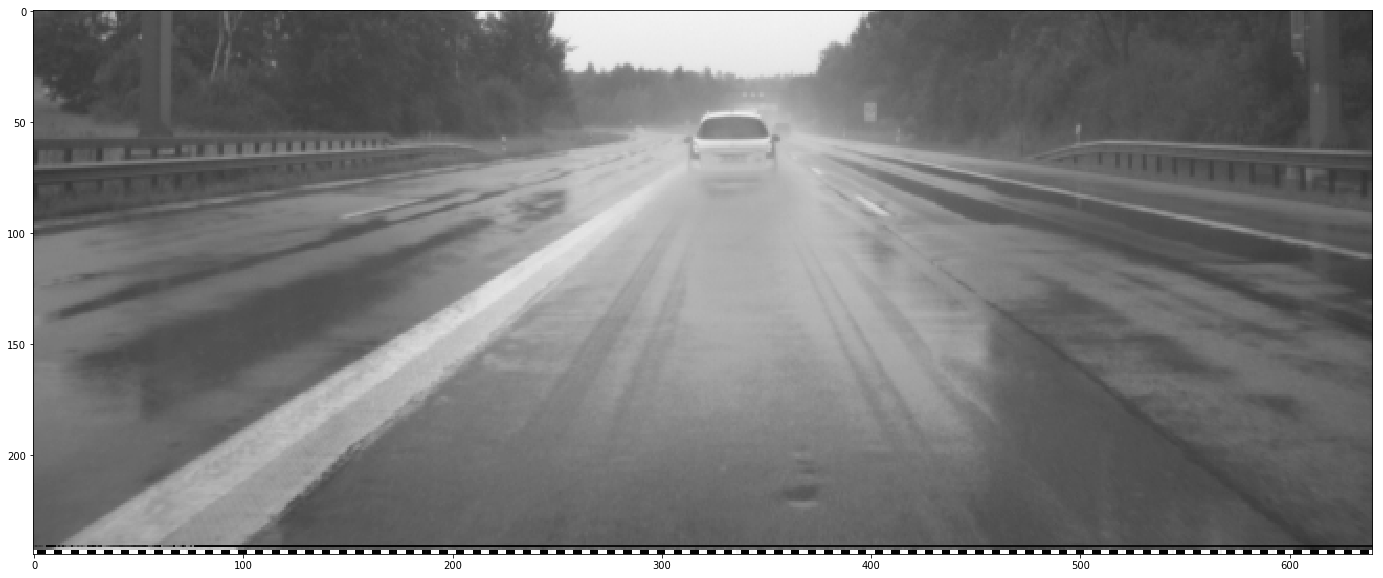

In [44]:
## Fold

index = 12400

if True:

#     img_sample = X_validation[index]
    img_sample = X_test[index]
#     img_sample = X_train[index]
    

    sh = img_sample.shape
    img = img_sample.reshape(sh[0], sh[1])

    plt.figure(figsize=(24,10))
    plt.imshow(img, cmap='gray', aspect='auto');
    # plt.colorbar()


#     score, max_index = composed_predict(img_sample.reshape(sh[0], sh[1]))
#     score *= 100

    
    score = model.predict(img_sample.reshape(1, sh[0], sh[1], sh[2]))
    score = score[0] * 100
    
    print(score)
    
    score = [round(x,2) for x in score]
          
    categs = ['Dry', 'Wet', 'Snow']

    label_categ = Y_test[index]
#     label_categ = Y_train[index]
#     label_categ = Y_validation[index]
    
    label = label_categ.argmax()
    
    print('Expected: ' + categs[label] + '\n')

    for i in range(len(score)):
        print(categs[i] + ' - ' + str(score[i]) + ' %')
        

### Browse an image and predict result

In [ ]:
for file in scandir(browse_src_directory):
    
    image_sample = cv2.imread(file.path, 0)
    print(image_sample.shape)
    
    height, width = image_sample.shape[:2]
    
    #CROP
    image_sample = image_sample[height // 3 : , :]
    
    #new height after crop
    height = image_sample.shape[0]

    #DOWNSAMPLE
    image_sample = cv2.resize(image_sample, (img_cols, img_rows), interpolation = cv2.INTER_AREA)
    
    image_sample = (image_sample.astype(float) - mean) / std
#     image_sample = image_sample.astype(float) / 128

#     print(image_sample.shape)
    print(np.min(image_sample))

    sh = image_sample.shape
    
    score, index = composed_predict(image_sample)
#     score = model.predict(image_sample.reshape(1, sh[0], sh[1], 1))
    print(score)
    print(index)
    
    plt.figure(figsize=(24,12))
    plt.imshow(image_sample, cmap='gray', aspect='auto');

# 6. Visualisation

### Obtain the outputs of each layer

In [46]:
#Fold

inp = model.input
outputs = [layer.output for layer in model.layers if layer.name.startswith('activation')]

feedForward = K.function([inp] + [K.learning_phase()], outputs)

# Testing

#img_sample = X_validation[2]

test = img_sample[np.newaxis, :]
layer_outs = feedForward([test, 1.])

print(layer_outs[0].shape)

# layer_outs = layer_outs[: len(layer_outs) - 4]

#reshape the outputs so that they are easier to plot
for layer, i in zip(layer_outs, range(len(layer_outs))):
    layer_outs[i] = np.swapaxes(layer_outs[i], 1, 3)
    layer_outs[i] = np.swapaxes(layer_outs[i], 2, 3)
    layer_outs[i] = layer_outs[i][0]
    print(layer_outs[i].shape)

# print(layer_outs[0].shape)


(1, 120, 317, 12)
(12, 120, 317)
(24, 28, 77)
(24, 24, 73)
(48, 10, 34)
(48, 8, 32)


### Plot activations on a particular layer

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


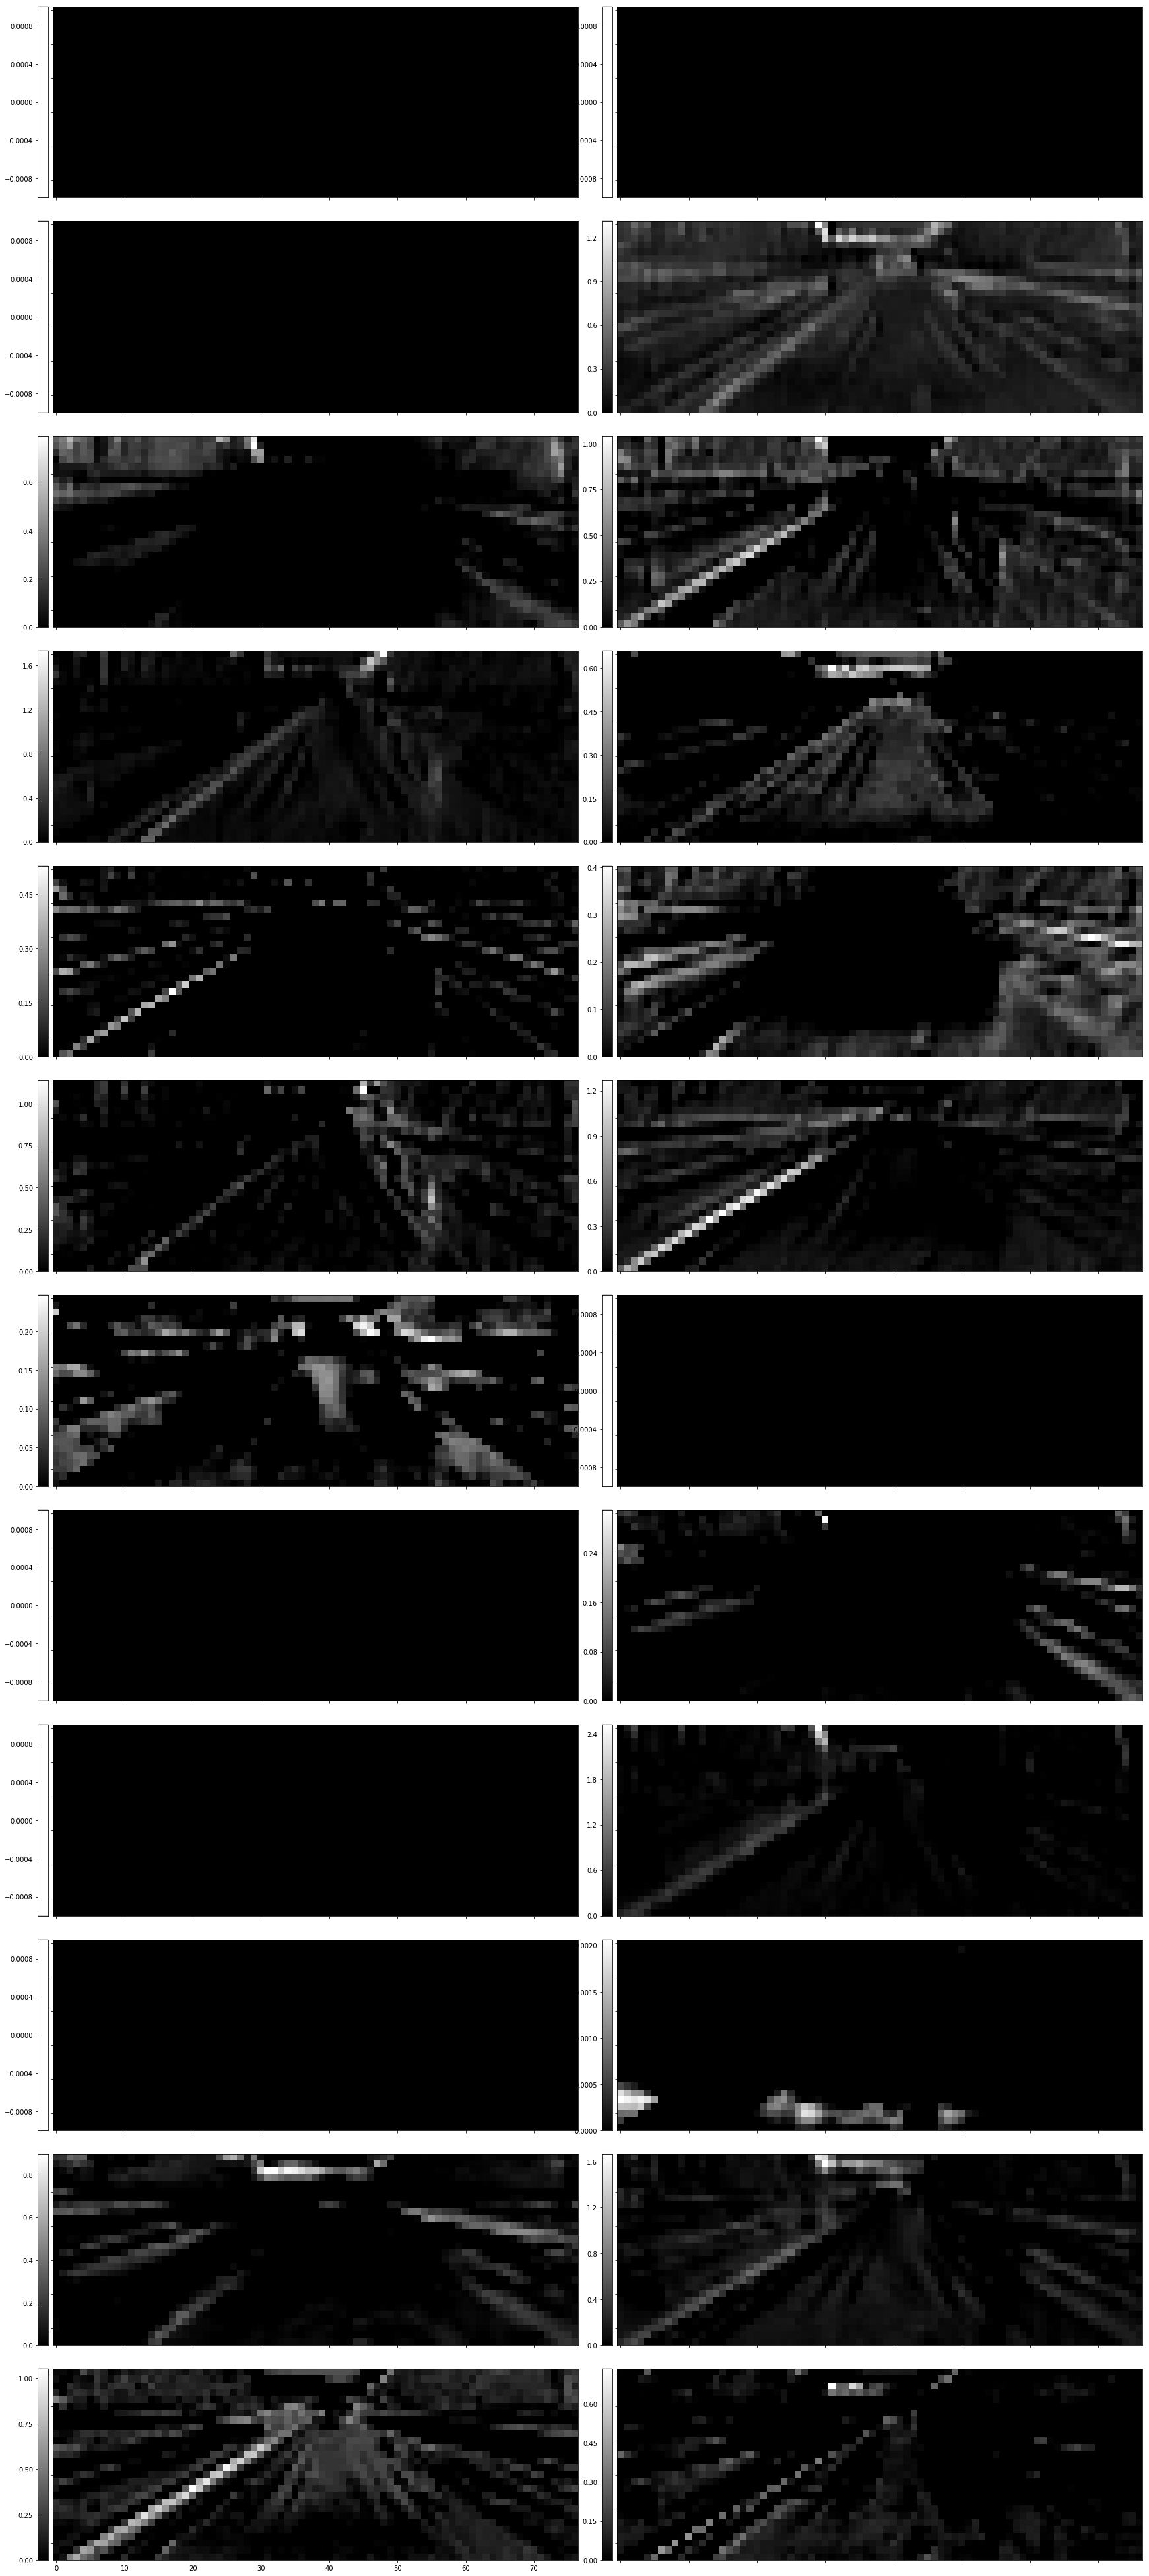

In [51]:
#Fold

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colors


layer = layer_outs[1]

# print(layer.shape)

extent = (-8, 4, -4, 3)
fig = plt.figure(1, (30, 100))


grid = ImageGrid(fig, 111,
                  nrows_ncols=(12, 2),
                  direction="row",
                  axes_pad=0.5,
                  add_all=True,
                  label_mode="1",
                  share_all=True,
#                   cbar_location="top",
#                   cbar_mode="single",
#                   cbar_size="5%",
                  cbar_location="left",
                  cbar_mode="each", 
                  cbar_size="2%",
                  cbar_pad=0.1,
                  )

# vmax, vmin = np.max(layer), np.min(layer)

for i in range (layer.shape[0]):

    vmax, vmin = np.max(layer[i]), np.min(layer[i])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

    im = grid[i].imshow(layer[i], norm=norm, #extent=extent,
                           cmap="gray",
#                            origin="lower",
                           interpolation="nearest")

    grid[i].cax.colorbar(im)
    grid[i].cax.toggle_label(True)

plt.draw()
plt.show()

### View Weights

In [ ]:
#Fold

[print(weights[i].shape) for i in range(len(weights))];

# w = weights[0].reshape(weights[0].shape[3], weights[0].shape[0], weights[0].shape[1])


w = weights[-2]

print(w.shape)


w = np.swapaxes(w, 0, 2)
w = np.swapaxes(w, 1, 3)
w = w[0]

print(w.shape)

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colors



# fig = plt.figure(1, (5, 10))
fig = plt.figure(1, (20, 40))

grid = ImageGrid(fig, 111,
                  nrows_ncols=(4, 3),
#                   nrows_ncols=(1, 2),
                  direction="row",
                  axes_pad=0.5,
                  add_all=True,
                  label_mode="1",
                  share_all=True,
#                   cbar_location="top",
#                   cbar_mode="single",
#                   cbar_size="5%",
                  cbar_location="left",
                  cbar_mode="each", 
                  cbar_size="2%",
                  cbar_pad=0.1,
                  )

print(w)
vmax, vmin = np.max(w), np.min(w)

print('Min: ' + str(vmin))
print('Max: ' + str(vmax))

for i in range (w.shape[0]):

    vmax, vmin = np.max(w[i]), np.min(w[i])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

    im = grid[i].imshow(w[i], norm=norm, #extent=extent,
                           cmap="gray",
#                            origin="lower", 
                           interpolation="nearest"
                       )

    grid[i].cax.colorbar(im)
    grid[i].cax.toggle_label(True)

plt.draw()
plt.show()